<a href="https://github.com/labrijisaad/Energy-Forecast-API/blob/main/notebooks/Machine Learning - Energy_Forecasting.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/Open%20in-GitHub-blue.svg" alt="Open In GitHub"/>
</a>

## <center><a><span style="color:blue">`Machine Learning` - Energy Forecasting Dataset</span></a></center>

Now, we will create our Machine Learning flow to train the model for future prediction. The **critical question** at this stage is: **how far into the future are we aiming to predict?** It's important to note that the farther ahead we predict, the greater the challenge for the model to make accurate predictions.

In our scenario, we'll focus on two distinct prediction horizons:

- **Short-term (`1-Day`)**: We aim to do **next-day** predictions. [Explore `1-Day` Future Predictions](#1-Day).
  
- **Long-term (`30-Day`)**:We aim to do a **month-ahead** predictions. [Explore `30-Day` Future Predictions](#30-Day).

### Import the needed libraries

In [1]:
# Supress warnings
import warnings ; warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd ; pd.set_option('display.max_columns', None) ; pd.set_option('display.max_rows', 4)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns ; color_pal = sns.color_palette("husl", 9) ; plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from colorama import Fore

# Machine Learning
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# XGBoost
import xgboost as xgb

# Utilities
from datetime import datetime, date
import math
import os
import re

# Data missingness visualization
import missingno as msno

# Progress bar
from tqdm import tqdm

#### Load Processed Data

In [2]:
weather_and_consumption_df = pd.read_csv('../data/processed/weather_and_consumption.csv', index_col=0, parse_dates=True)
weather_and_consumption_df.head(1)

total_consumption  Global_reactive_power   Voltage  \
2006-12-16           1209.176                 34.922  93552.53   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
2006-12-16            5180.8             0.0           546.0          4926.0   

            tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
2006-12-16      8.2      3.4   5.7           5.7           0.6        2.9   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
2006-12-16  4.1      89.8   1.853         100        29.17   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
2006-12-16      39.8       19.1    235.4            1023.2        68.6   

            visibility  moonphase  conditions_clear  conditions_overcast  \
2006-12-16        10.2       0.87             False                False   

            conditions_partiallycloudy  conditions_rain  \
2006-12-16                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
2006-12-16                    False                            True   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
2006-12-16                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
2006-12-16                False                        False   

            conditions_snowrainpartiallycloudy  day_length  is_holiday  
2006-12-16                               False    8.278889       False

In [3]:
weather_and_consumption_df.columns

Index(['total_consumption', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'moonphase',
       'conditions_clear', 'conditions_overcast', 'conditions_partiallycloudy',
       'conditions_rain', 'conditions_rainovercast',
       'conditions_rainpartiallycloudy', 'conditions_snowovercast',
       'conditions_snowpartiallycloudy', 'conditions_snowrain',
       'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
       'day_length', 'is_holiday'],
      dtype='object')

#### Copy the Data

In [4]:
df = weather_and_consumption_df.copy()

## <center><a class="anchor" id="1-Day"><span style="color:green">Training Models for `1-Day` Future Predictions</span></a></center>

### <a><span style="color:red">Feature Engineering based on the `EDA`</span></a>

In [5]:
def create_features(df, column_names, lags, window_sizes):
    """
    Create time series features based on time series index and add lag and rolling features for specified columns.
    """
    # List to store created feature names
    created_features = []

    # Basic time series features
    basic_features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
    for feature in basic_features:
        # Add basic time series features to the DataFrame
        df[feature] = getattr(df.index, feature)
        created_features.append(feature)
    
    for column_name in column_names:
        # Lag features for each specified column
        for lag in lags:
            lag_feature_name = f'{column_name}_lag_{lag}'
            df[lag_feature_name] = df[column_name].shift(lag)
            created_features.append(lag_feature_name)
        
        # Rolling window features for each specified column
        for window in window_sizes:
            rolling_mean_name = f'{column_name}_rolling_mean_{window}'
            df[rolling_mean_name] = df[column_name].shift(1).rolling(window=window).mean()
            created_features.append(rolling_mean_name)
        
    return df, created_features

In [6]:
# Apply the Feature Engineering Function 
df, created_features = create_features(df, 
                                     column_names=['total_consumption', 'Global_intensity', 'Sub_metering_3', 'Sub_metering_1', 
                                                    'temp', 'day_length', 'tempmax', 'feelslike', 'feelslikemax', 'feelslikemin', 'tempmin'], 
                                     lags=[1, 2, 3, 4, 5, 6, 7, 30, 90, 365], 
                                     window_sizes=[2, 3, 4, 5, 6, 7, 30, 90, 365])

### <a><span style="color:red">Train / Test Split</span></a>
#### Define The Features and the Target

In [7]:
# External Features that we managed to add
EXTERNAL_FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 
                     'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 
                     'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase', 'conditions_clear', 
                     'conditions_overcast', 'conditions_partiallycloudy', 'conditions_rain', 'conditions_rainovercast',
                     'conditions_rainpartiallycloudy', 'conditions_snowovercast', 'conditions_snowpartiallycloudy', 
                     'conditions_snowrain', 'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy', 
                     'day_length', 'is_holiday']

# Features got with feature engineering
FEATURES = created_features

# Target Column
TARGET = 'total_consumption'

In [8]:
df.tail(2)

total_consumption  Global_reactive_power    Voltage  \
2010-11-25           1431.164                116.128  347812.21   
2010-11-26           1488.104                120.826  303487.57   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
2010-11-25            6004.0          1076.0           426.0          5072.0   
2010-11-26            6259.8          1080.0           385.0          9989.0   

            tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
2010-11-25      4.4      0.6   3.0           3.6          -3.0        0.9   
2010-11-26      2.8     -1.1   0.5           0.4          -5.8       -3.1   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
2010-11-25  0.8      85.8   0.987         100         25.0   0.0        0.0   
2010-11-26 -1.3      88.3   0.091         100         12.5   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
2010-11-25      33.4       13.6    309.4            1006.2        82.6   
2010-11-26      34.5       17.8    258.8            1007.7        66.7   

            visibility  moonphase  conditions_clear  conditions_overcast  \
2010-11-25        14.9       0.63             False                False   
2010-11-26        13.1       0.67             False                False   

            conditions_partiallycloudy  conditions_rain  \
2010-11-25                       False            False   
2010-11-26                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
2010-11-25                    False                           False   
2010-11-26                    False                           False   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
2010-11-25                    False                           False   
2010-11-26                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
2010-11-25                False                        False   
2010-11-26                False                        False   

            conditions_snowrainpartiallycloudy  day_length  is_holiday  \
2010-11-25                                True    8.777500       False   
2010-11-26                                True    8.741111       False   

            dayofweek  quarter  month  year  dayofyear  \
2010-11-25          3        4     11  2010        329   
2010-11-26          4        4     11  2010        330   

            total_consumption_lag_1  total_consumption_lag_2  \
2010-11-25                 1796.248                 1577.536   
2010-11-26                 1431.164                 1796.248   

            total_consumption_lag_3  total_consumption_lag_4  \
2010-11-25                 2041.536                  900.910   
2010-11-26                 1577.536                 2041.536   

            total_consumption_lag_5  total_consumption_lag_6  \
2010-11-25                 2197.006                 1570.400   
2010-11-26                  900.910                 2197.006   

            total_consumption_lag_7  total_consumption_lag_30  \
2010-11-25                 1652.152                   945.904   
2010-11-26                 1570.400                  1260.278   

            total_consumption_lag_90  total_consumption_lag_365  \
2010-11-25                  2030.650                   1980.130   
2010-11-26                  1442.856                   1599.626   

            total_consumption_rolling_mean_2  \
2010-11-25                          1686.892   
2010-11-26                          1613.706   

            total_consumption_rolling_mean_3  \
2010-11-25                       1805.106667   
2010-11-26                       1601.649333   

            total_consumption_rolling_mean_4  \
2010-11-25                         1579.0575   
2010-11-26                         1711.6210   

            total_consumption_rolling_

Let's first train the model on historical data and evaluate its performance in the future. We can split the data as follows:
- Training data consists of records where the date is before `2010-05-17`.
- Testing data consists of records where the date is on or after `2010-05-17`

##### Define the Train / Test Data

In [9]:
# Define a Threshold
threshold = '2010-05-17'

# Splitting the data into train and test sets based on the defined Threshold
train_df = df.loc[df.index < threshold].copy()
test_df = df.loc[df.index >= threshold].copy()

# Define the X_train / y_train
X_train = train_df[FEATURES+EXTERNAL_FEATURES]
y_train = train_df[TARGET]

# Define the X_test / y_test
X_test = test_df[FEATURES+EXTERNAL_FEATURES]
y_test = test_df[TARGET]

##### Plot the Train / Test Data

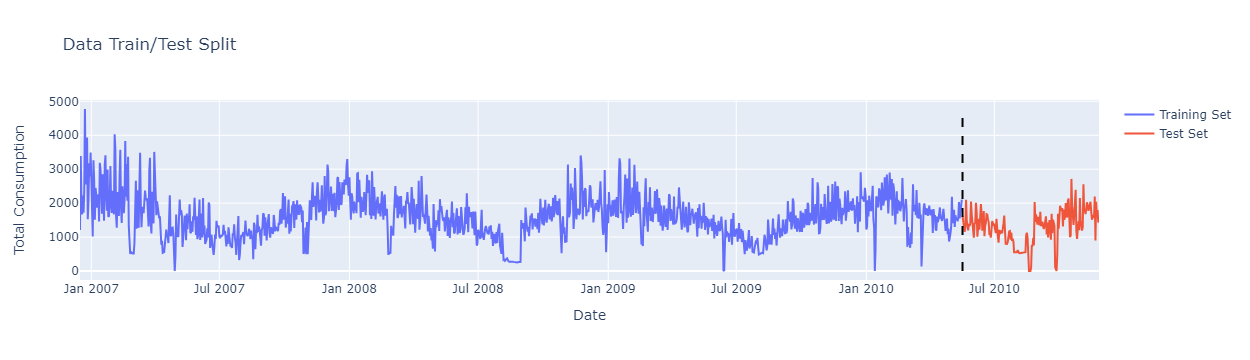

In [10]:
# Plotly graph objects for training and test sets
trace1 = go.Scatter(x=train_df.index, y=train_df.total_consumption, mode='lines', name='Training Set')
trace2 = go.Scatter(x=test_df.index, y=test_df.total_consumption, mode='lines', name='Test Set')

# Add a vertical line for the train-test split date based 
vline = go.layout.Shape(type="line", x0=threshold, y0=0, x1=threshold, y1=max(df.total_consumption),
                        line=dict(color="Black", width=2, dash="dash"))

layout = go.Layout(title='Data Train/Test Split',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Total Consumption'),
                   shapes=[vline])

fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

### <a><span style="color:red">Training Models for Predicting `1-Day` Ahead</span></a>

In this scenario, our goal is to train a model to forecast values one day into the future. This task involves using a **1-day lag**, which makes the challenge quite straightforward. We expect the 1-day lag feature to be crucial after training.

To evaluate performance, we'll develop and train several types of models: a **Random Forest**, an **XGBoost regressor** models.s.

In [11]:
X_train.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'total_consumption_lag_1', 'total_consumption_lag_2',
       'total_consumption_lag_3', 'total_consumption_lag_4',
       'total_consumption_lag_5',
       ...
       'conditions_rain', 'conditions_rainovercast',
       'conditions_rainpartiallycloudy', 'conditions_snowovercast',
       'conditions_snowpartiallycloudy', 'conditions_snowrain',
       'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
       'day_length', 'is_holiday'],
      dtype='object', length=247)

#### Instantiate Models

In [12]:
# Instantiate Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=600, max_depth=3)

# Instantiate XGBoost Regressor
import xgboost as xgb
xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

#### Train Models

In [13]:
# Train the Random Forest Regressor model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=600)

In [14]:
# Train the XGBoost Regressor
xgb.fit(X_train, y_train, verbose=100,
        eval_set=[(X_train, y_train), (X_train, y_train)])

[0]	validation_0-rmse:1692.35197	validation_1-rmse:1692.35197
[100]	validation_0-rmse:730.39091	validation_1-rmse:730.39091
[200]	validation_0-rmse:441.24195	validation_1-rmse:441.24195
[300]	validation_0-rmse:363.25035	validation_1-rmse:363.25035
[400]	validation_0-rmse:335.57598	validation_1-rmse:335.57598
[500]	validation_0-rmse:320.57238	validation_1-rmse:320.57238
[600]	validation_0-rmse:306.52118	validation_1-rmse:306.52118
[700]	validation_0-rmse:293.97399	validation_1-rmse:293.97399
[800]	validation_0-rmse:283.77272	validation_1-rmse:283.77272
[900]	validation_0-rmse:274.68401	validation_1-rmse:274.68401
[999]	validation_0-rmse:266.52789	validation_1-rmse:266.52789


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#### Plot the Feature Importance

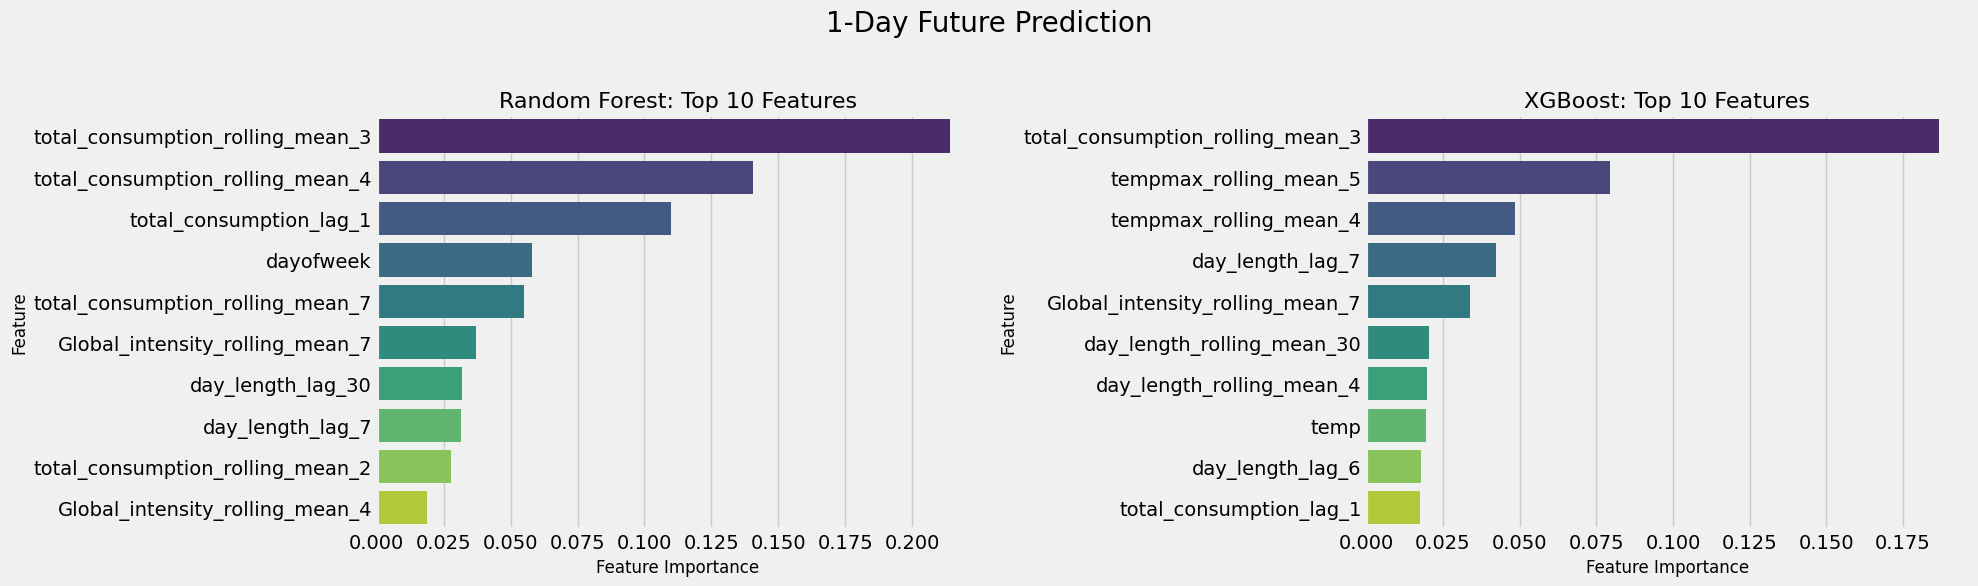

In [15]:
# Create DataFrame for feature importances
feature_data_rfr = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': rfr.feature_importances_,
    'Model': 'Random Forest'
})

feature_data_xgb = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': xgb.feature_importances_,
    'Model': 'XGBoost'
})

# Combine the DataFrames
feature_data_combined = pd.concat([feature_data_rfr, feature_data_xgb])

# Sort each DataFrame by importance and select the top 10 features
top_features_rfr = feature_data_rfr.sort_values(by='Importance', ascending=False).head(10)
top_features_xgb = feature_data_xgb.sort_values(by='Importance', ascending=False).head(10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 line, 2 plots

# Random Forest
sns.barplot(data=top_features_rfr, x='Importance', y='Feature', palette='viridis', ax=axs[0])
axs[0].set_title('Random Forest: Top 10 Features', fontsize=16)
axs[0].set_xlabel('Feature Importance', fontsize=12)
axs[0].set_ylabel('Feature', fontsize=12)

# XGBoost
sns.barplot(data=top_features_xgb, x='Importance', y='Feature', palette='viridis', ax=axs[1])
axs[1].set_title('XGBoost: Top 10 Features', fontsize=16)
axs[1].set_xlabel('Feature Importance', fontsize=12)
axs[1].set_ylabel('Feature', fontsize=12)

# Add main title
plt.suptitle("1-Day Future Prediction", fontsize=20)

# Adjust layout before setting the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot as an image file
plt.savefig('../results/top_features_comparison_1-Day_Future_Prediction.png')

# Display the plot
plt.show()

#### Analyse the Models Performances

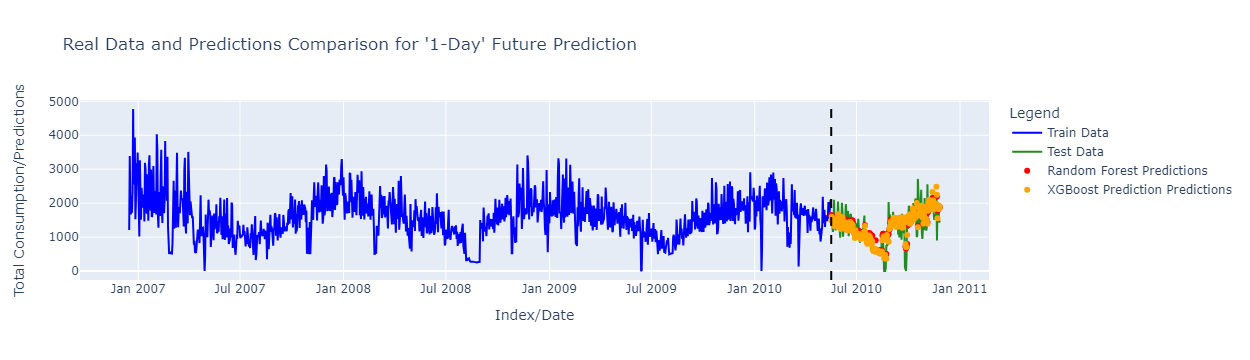

Random Forest RMSE: 361.59441530949886
XGBoost RMSE: 367.481973834411


In [16]:
# Adding Random Forest predictions to the test set DataFrame
test_df['RandomForest_Prediction'] = rfr.predict(X_test)
test_df['XGBoost_Prediction'] = xgb.predict(X_test)

df_final = df.merge(test_df[['RandomForest_Prediction', 'XGBoost_Prediction']], how='left', left_index=True, right_index=True)

# Plotly graph for truth data and predictions
train_data = go.Scatter(x=train_df.index, y=train_df['total_consumption'], mode='lines', name='Train Data', line=dict(color='Blue'))
test_data = go.Scatter(x=test_df.index, y=test_df['total_consumption'], mode='lines', name='Test Data', line=dict(color='ForestGreen'))
random_forest_predictions = go.Scatter(x=df_final.index, y=df_final['RandomForest_Prediction'], mode='markers', name='Random Forest Predictions', marker=dict(color='Red'))
xgboost_predictions = go.Scatter(x=df_final.index, y=df_final['XGBoost_Prediction'], mode='markers', name='XGBoost Prediction Predictions', marker=dict(color='Orange'))

# Adding a vertical line for the train-test split date
vline = dict(
    type="line", x0=threshold, y0=0, x1=threshold, y1=1, line=dict(color="Black", width=2, dash="dash"), xref='x', yref='paper'
)
# Update layout for a better visual presentation
layout = go.Layout(
    title="Real Data and Predictions Comparison for '1-Day' Future Prediction",
    xaxis=dict(title='Index/Date'),
    yaxis=dict(title='Total Consumption/Predictions'),
    legend_title='Legend',
    shapes=[vline]
)

fig = go.Figure(data=[train_data, test_data, random_forest_predictions, xgboost_predictions], layout=layout)

# Show the interactive plot
fig.show()

# Calculate the RMSE for the Random Forest Model on the Test Data
y_pred_rfr = rfr.predict(X_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print(f"Random Forest RMSE: {rmse_rfr}")

# Calculate the RMSE for the XGBoost Model on the Test Data
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

# Save the interactive plot as HTML file
pio.write_html(fig, file='../results/Real Data and Predictions Comparison for 1-Day Future Prediction.html')

[🔍 Open Figure](https://htmlpreview.github.io/?https://github.com/labrijisaad/Energy-Forecast-API/blob/main/results/Real%20Data%20and%20Predictions%20Comparison%20for%201-Day%20Future%20Prediction.html)

## <center><a class="anchor" id="30-Day"><span style="color:green">Training Models for `30-Day` Future Predictions</span></a></center>

In our second scenario, we focus on developing a model to forecast values 30 days into the future. This presents a significantly more challenging task. To enhance the model's performance, we will emplo**y Time Series Cross-Validati**on. This approach involves repeatedly training the model on the dataset using **a sliding window techniq****ue, aiming for predictions spanning 30 days. For clarity and insight, these predictions will be visualized through plottingIWe plan to build and train two types of models: **e Random Fore**st and a**n XGBoost regress**or. Additionally, we will visualize the feature importance to identify which factors most influence the model's predictions.

### <a><span style="color:red">Time Series `Cross Validation`</span></a>

##### Prepare the Data Create Features for the 30-Day Future Predictions

In [17]:
# Copy the Original Dataset
df = weather_and_consumption_df.copy()

# Apply the Feature Engineering Function 
df, created_features = create_features(df, 
                         column_names=['total_consumption', 'Global_intensity', 'Sub_metering_3', 'Sub_metering_1', 
                                                    'temp', 'day_length', 'tempmax', 'feelslike', 'feelslikemax', 'feelslikemin', 'tempmin'], 
                         lags=[30, 40, 50, 60, 90, 365], 
                         window_sizes=[30, 40, 50, 60, 90, 365])

# Features got with feature engineering
FEATURES = created_features

# External Features that we managed to add
EXTERNAL_FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
                     'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
                     'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
                     'sealevelpressure', 'cloudcover', 'visibility', 'moonphase',
                     'conditions_clear', 'conditions_overcast', 'conditions_partiallycloudy',
                     'conditions_rain', 'conditions_rainovercast',
                     'conditions_rainpartiallycloudy', 'conditions_snowovercast',
                     'conditions_snowpartiallycloudy', 'conditions_snowrain',
                     'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
                     'day_length', 'is_holiday']

# Target Column
TARGET = 'total_consumption'

##### Split Data into Train / Test sets 

In [18]:
# Define a Threshold
threshold = '2010-05-17'

# Splitting the data into train and test sets based on the defined Threshold
train_df_cv = df.loc[df.index < threshold].copy()
test_df_cv = df.loc[df.index >= threshold].copy()

# Define the X_train / y_train  and X_test / y_test 
X_train_cv = train_df_cv[FEATURES+EXTERNAL_FEATURES]
y_train_cv = train_df_cv[TARGET]

X_test_cv = test_df_cv[FEATURES+EXTERNAL_FEATURES]
y_test_cv = test_df_cv[TARGET]

##### Viz the Train / Test data

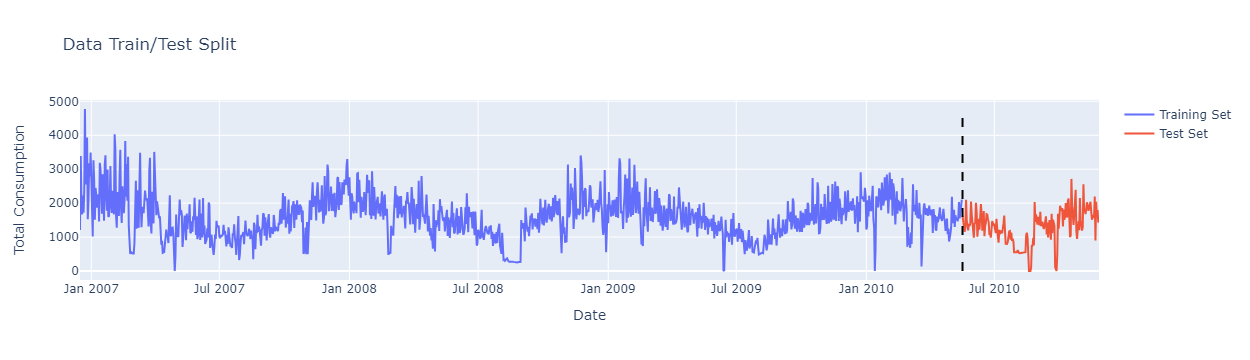

In [19]:
# Creating Plotly graph objects for training and test sets
trace1 = go.Scatter(x=train_df_cv.index, y=train_df_cv.total_consumption, mode='lines', name='Training Set')
trace2 = go.Scatter(x=test_df_cv.index, y=test_df_cv.total_consumption, mode='lines', name='Test Set')

# Adding a vertical line for the train-test split date
vline = go.layout.Shape(type="line", x0=threshold, y0=0, x1=threshold, y1=max(df.total_consumption),
                        line=dict(color="Black", width=2, dash="dash"))

layout = go.Layout(title='Data Train/Test Split',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Total Consumption'),
                   shapes=[vline])

fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

##### Set up the 7-folds Time Series Split on the Train data

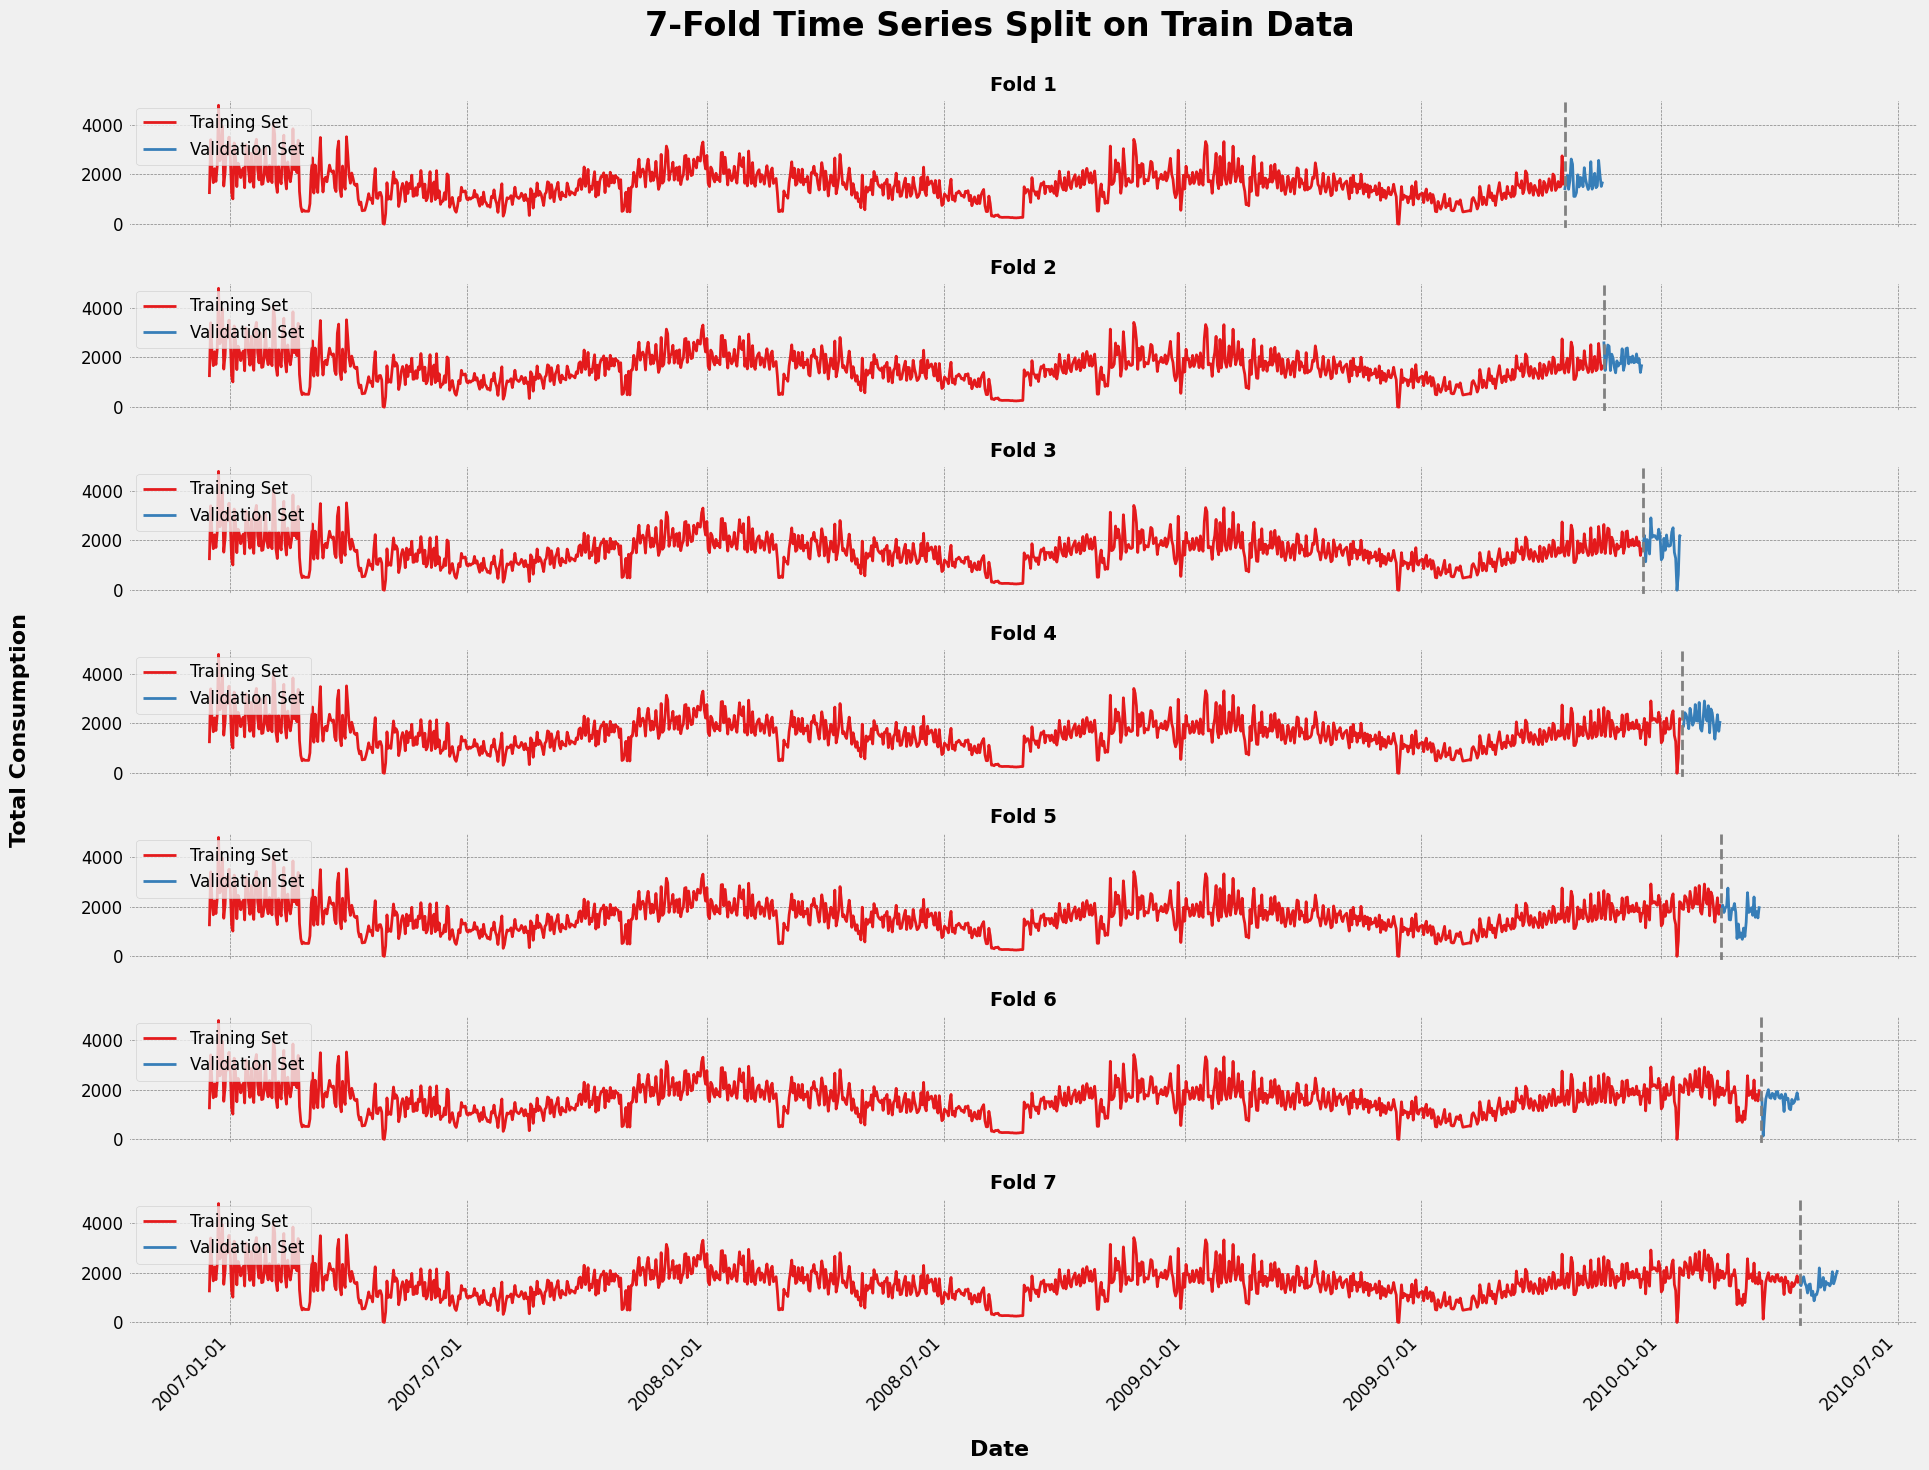

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=7, test_size=30)

fig, axs = plt.subplots(7, 1, figsize=(20, 15), sharex=True)

# Define a color palette
color_palette = plt.get_cmap('Set1')

for fold, (train_idx, val_idx) in enumerate(tss.split(train_df_cv)):
    train_cv = df.iloc[train_idx]
    test_cv = df.iloc[val_idx]
    
    # Plot Training Set
    axs[fold].plot(train_cv.index, train_cv[TARGET], label='Training Set', linewidth=2, color=color_palette(0))
    
    # Plot Test Set
    axs[fold].plot(test_cv.index, test_cv[TARGET], label='Validation Set', color=color_palette(1), linewidth=2)
    
    # Mark the beginning of the test set
    axs[fold].axvline(test_cv.index.min(), color='gray', ls='--', lw=2)
    
    # Set title for each subplot
    axs[fold].set_title(f'Fold {fold+1}', fontsize=14, fontweight='bold')
    
    # Format the x-axis with dates
    axs[fold].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[fold].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(axs[fold].xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=12)

    # Improve readability
    axs[fold].tick_params(axis='y', labelsize=12)
    axs[fold].grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')
    axs[fold].legend(fontsize=12, loc='upper left')

# Improve layout to prevent label overlap and set a shared xlabel
fig.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
fig.subplots_adjust(hspace=0.4)  
fig.text(0.5, 0.02, 'Date', ha='center', va='center', fontsize=16, fontweight='bold')
fig.text(0.01, 0.5, 'Total Consumption', ha='center', va='center', rotation='vertical', fontsize=16, fontweight='bold')

# Figure title
fig.suptitle("7-Fold Time Series Split on Train Data", fontsize=24, fontweight='bold', y=0.98)

# Save the plot as an image file
plt.savefig('../results/7-Fold Time Series Split on Train Data.png')

plt.show()

##### Viz the Features that will be used in Training

In [21]:
X_train_cv.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'total_consumption_lag_30', 'total_consumption_lag_40',
       'total_consumption_lag_50', 'total_consumption_lag_60',
       'total_consumption_lag_90',
       ...
       'conditions_rain', 'conditions_rainovercast',
       'conditions_rainpartiallycloudy', 'conditions_snowovercast',
       'conditions_snowpartiallycloudy', 'conditions_snowrain',
       'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
       'day_length', 'is_holiday'],
      dtype='object', length=170)

#### Instantiate Models

In [22]:
# Define the Random Forest Regressor
rfr_cv = RandomForestRegressor(n_estimators=600, max_depth=3)

# Define the XGBoost Regressor
import xgboost as xgb
xgb_cv = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=2000,
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.05)

#### Train Models

In [23]:
preds = []
scores = []

for fold, (train_idx, val_idx) in tqdm(enumerate(tss.split(X_train_cv))):
    X_train_fold = X_train_cv.iloc[train_idx]
    y_train_fold = y_train_cv.iloc[train_idx]
    X_val_fold = X_train_cv.iloc[val_idx]
    y_val_fold = y_train_cv.iloc[val_idx]

    # Fit the Random Forest model
    rfr_cv.fit(X_train_fold, y_train_fold)
    # Predict on the validation set
    y_pred_rfr = rfr_cv.predict(X_val_fold)
    # Calculate and store the score for Random Forest
    score_rfr = np.sqrt(mean_squared_error(y_val_fold, y_pred_rfr))
    print(f"Fold {fold}: Random Forest Regressor RMSE = {score_rfr}")
    
    # Fit the XGBoost model with early stopping
    xgb_cv.fit(X_train_fold, y_train_fold, verbose=100,
               eval_set=[(X_val_fold, y_val_fold)])
    # Predict on the validation set using the best iteration
    y_pred_xgb = xgb_cv.predict(X_val_fold)
    # Calculate and store the score for XGBoost
    score_xgb = np.sqrt(mean_squared_error(y_val_fold, y_pred_xgb))
    print(f"Fold {fold}: XGBoost Regressor RMSE = {score_xgb}")
    
    # Storing predictions and scores
    preds.append({'RF': y_pred_rfr, 'XGB': y_pred_xgb})
    scores.append({'RF': score_rfr, 'XGB': score_xgb})

# Optionally, calculate and print the average score across all folds for each model
avg_score_rfr = np.mean([score['RF'] for score in scores])
avg_score_xgb = np.mean([score['XGB'] for score in scores])
print(f"Random Forest Regressor Average RMSE across all folds: {avg_score_rfr}")
print(f"XGBoost Regressor Average RMSE across all folds: {avg_score_xgb}")

0it [00:00, ?it/s]

Fold 0: Random Forest Regressor RMSE = 412.5376652010024
[0]	validation_0-rmse:1702.44523
[100]	validation_0-rmse:395.59779
[200]	validation_0-rmse:390.73851
[211]	validation_0-rmse:391.18415


1it [00:26, 26.22s/it]

Fold 0: XGBoost Regressor RMSE = 388.829424525812
Fold 1: Random Forest Regressor RMSE = 337.18466293948796
[0]	validation_0-rmse:1827.46869
[100]	validation_0-rmse:323.66110
[107]	validation_0-rmse:326.34994


2it [00:53, 26.89s/it]

Fold 1: XGBoost Regressor RMSE = 315.6364656877104
Fold 2: Random Forest Regressor RMSE = 597.5035033729274
[0]	validation_0-rmse:1824.77886
[97]	validation_0-rmse:591.37309


3it [01:21, 27.51s/it]

Fold 2: XGBoost Regressor RMSE = 587.2505945326611
Fold 3: Random Forest Regressor RMSE = 459.355534538863
[0]	validation_0-rmse:2091.32441
[97]	validation_0-rmse:630.00638


4it [01:48, 27.26s/it]

Fold 3: XGBoost Regressor RMSE = 583.9996961718422
Fold 4: Random Forest Regressor RMSE = 531.5564072241352
[0]	validation_0-rmse:1645.16309
[100]	validation_0-rmse:538.19516
[104]	validation_0-rmse:539.15055


5it [02:16, 27.42s/it]

Fold 4: XGBoost Regressor RMSE = 523.9810828629661
Fold 5: Random Forest Regressor RMSE = 413.5111888039181
[0]	validation_0-rmse:1533.75502
[100]	validation_0-rmse:394.96259
[101]	validation_0-rmse:394.60286


6it [02:45, 28.01s/it]

Fold 5: XGBoost Regressor RMSE = 384.238876083211
Fold 6: Random Forest Regressor RMSE = 304.20547279029466
[0]	validation_0-rmse:1488.71164
[100]	validation_0-rmse:279.30323
[200]	validation_0-rmse:268.12883
[249]	validation_0-rmse:271.07217


7it [03:16, 28.09s/it]

Fold 6: XGBoost Regressor RMSE = 268.05147408091227
Random Forest Regressor Average RMSE across all folds: 436.550633552947
XGBoost Regressor Average RMSE across all folds: 435.9982305635878


#### Analyse the Models Performances RMSE while Training using Cross Validation

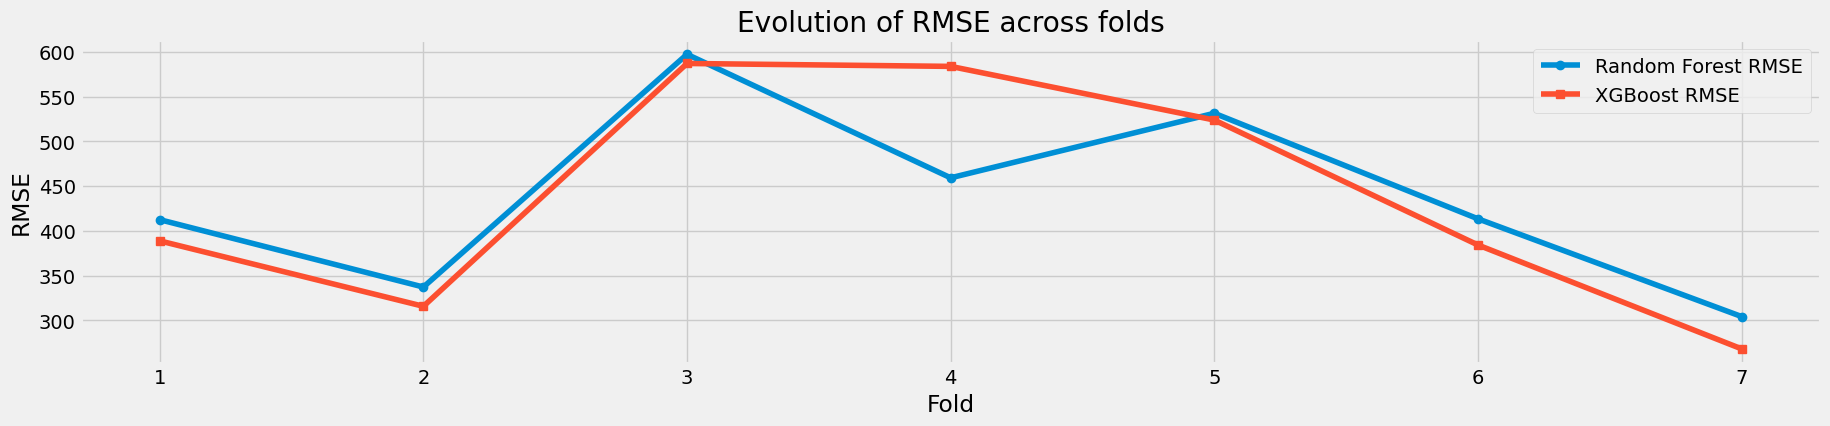

In [24]:
# Extract RMSE scores for each model
rf_rmse_scores = [score['RF'] for score in scores]
xgb_rmse_scores = [score['XGB'] for score in scores]
folds = list(range(1, len(rf_rmse_scores) + 1))

# Plotting
plt.figure(figsize=(20, 4))
plt.plot(folds, rf_rmse_scores, marker='o', label='Random Forest RMSE')
plt.plot(folds, xgb_rmse_scores, marker='s', label='XGBoost RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Evolution of RMSE across folds')
plt.legend()
plt.grid(True)
plt.xticks(folds)

# Save the plot as an image file
plt.savefig('../results/Evolution of RMSE across folds.png')

# Diplay the figure
plt.show()

#### Plot the Feature Importance

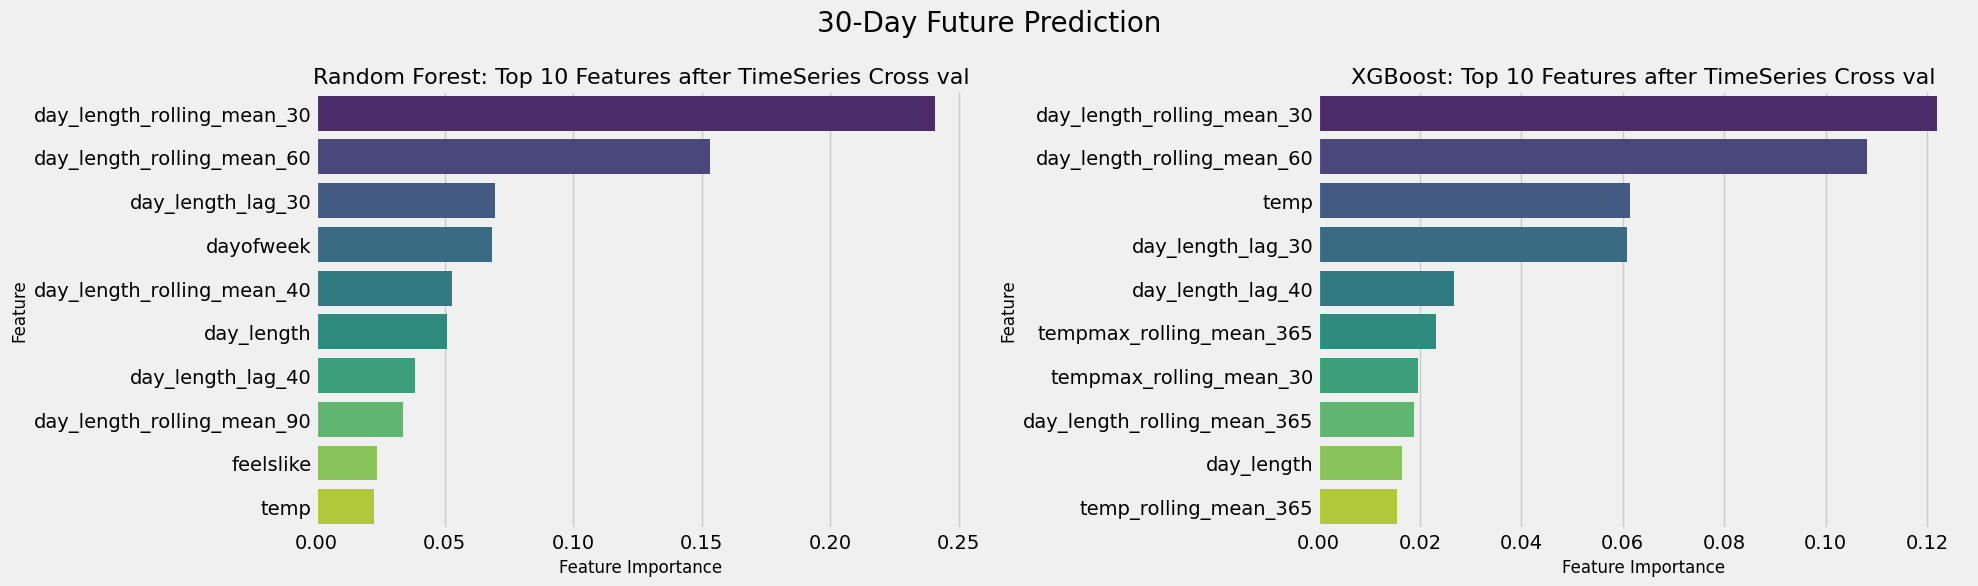

In [25]:
# Create DataFrame for Random Forest feature importances
feature_data_rfr = pd.DataFrame({
    'Feature': X_train_cv.columns, 
    'Importance': rfr_cv.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# Create DataFrame for XGBoost feature importances
feature_data_xgb = pd.DataFrame({
    'Feature': X_train_cv.columns, 
    'Importance': xgb_cv.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 line, 2 plots

# Random Forest
sns.barplot(data=feature_data_rfr, x='Importance', y='Feature', palette='viridis', ax=axs[0])
axs[0].set_title('Random Forest: Top 10 Features after TimeSeries Cross val', fontsize=16)
axs[0].set_xlabel('Feature Importance', fontsize=12)
axs[0].set_ylabel('Feature', fontsize=12)

# XGBoost
sns.barplot(data=feature_data_xgb, x='Importance', y='Feature', palette='viridis', ax=axs[1])
axs[1].set_title('XGBoost: Top 10 Features after TimeSeries Cross val', fontsize=16)
axs[1].set_xlabel('Feature Importance', fontsize=12)
axs[1].set_ylabel('Feature', fontsize=12)

# Add main title
plt.suptitle("30-Day Future Prediction", fontsize=20)

# Adjust layout
plt.tight_layout()

# Save the plot as an image file
plt.savefig('../results/top_features_comparison_30-Day_Future_Prediction.png')

# Display the plot
plt.show()

#### Analyse the Models Performances on Test data after Cross Validation

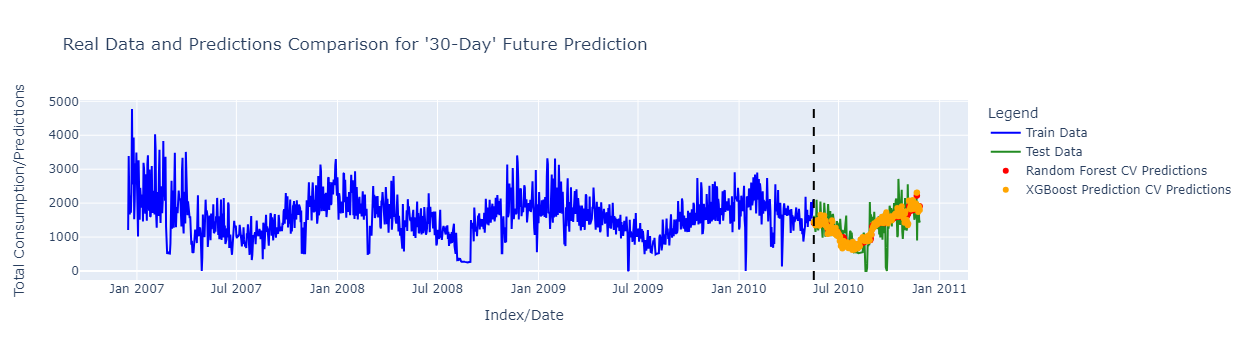

Random Forest RMSE: 405.014571178835
XGBoost RMSE: 428.23373516305946


In [26]:
# Adding Random Forest predictions to the test set DataFrame
test_df_cv['RandomForest_Prediction_cv'] = rfr_cv.predict(X_test_cv)
test_df_cv['XGBoost_Prediction_cv'] = xgb_cv.predict(X_test_cv)


df_final = df.merge(test_df_cv[['RandomForest_Prediction_cv', 'XGBoost_Prediction_cv']], how='left', left_index=True, right_index=True)

# Plotly graph for truth data and predictions
train_data = go.Scatter(x=train_df_cv.index, y=train_df_cv['total_consumption'], mode='lines', name='Train Data', line=dict(color='Blue'))
test_data = go.Scatter(x=test_df_cv.index, y=test_df_cv['total_consumption'], mode='lines', name='Test Data', line=dict(color='ForestGreen'))
random_forest_predictions = go.Scatter(x=df_final.index, y=df_final['RandomForest_Prediction_cv'], mode='markers', name='Random Forest CV Predictions', marker=dict(color='Red'))
xgboost_predictions = go.Scatter(x=df_final.index, y=df_final['XGBoost_Prediction_cv'], mode='markers', name='XGBoost Prediction CV Predictions', marker=dict(color='Orange'))

# Adding a vertical line for the train-test split date
vline = dict(
    type="line", x0=threshold, y0=0, x1=threshold, y1=1, line=dict(color="Black", width=2, dash="dash"), xref='x', yref='paper'
)

# Update layout for a better visual presentation
layout = go.Layout(
    title="Real Data and Predictions Comparison for '30-Day' Future Prediction",
    xaxis=dict(title='Index/Date'),
    yaxis=dict(title='Total Consumption/Predictions'),
    legend_title='Legend',
    shapes=[vline]  # Adding the vertical line to the layout
)

fig = go.Figure(data=[train_data, test_data, random_forest_predictions, xgboost_predictions], layout=layout)

# Show the interactive plot
fig.show()

# Calculate the RMSE for the Random Forest Model on the Test Data
y_pred_rfr_cv = rfr_cv.predict(X_test_cv)
rmse_rfr_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_rfr_cv))
print(f"Random Forest RMSE: {rmse_rfr_cv}")

# Calculate the RMSE for the XGBoost Model on the Test Data
y_pred_xgb_cv = xgb_cv.predict(X_test_cv)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_xgb_cv))
print(f"XGBoost RMSE: {rmse_xgb_cv}")

# Save the interactive plot as HTML file
pio.write_html(fig, file='../results/Real Data and Predictions Comparison for 30-Day Future Prediction.html')

[🔍 Open Figure](https://htmlpreview.github.io/?https://github.com/labrijisaad/Energy-Forecast-API/blob/main/results/Real%20Data%20and%20Predictions%20Comparison%20for%2030-Day%20Future%20Prediction.html)

## Connect with me 🌐
<div align="center">
  <a href="https://www.linkedin.com/in/labrijisaad/">
    <img src="https://img.shields.io/badge/LinkedIn-%230077B5.svg?&style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn" style="margin-bottom: 5px;"/>
  </a>
  <a href="https://github.com/labrijisaad">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="GitHub" style="margin-bottom: 5px;"/>
  </a>
</div>